In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pymongo import MongoClient
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import pymysql
import seaborn as sns
import datetime


# CNN
from keras.layers.convolutional import Conv1D

# RNN
from keras.layers.recurrent import LSTM

In [1]:
agg = [
    {
        '$sample': {
            'size': n_df_size
        }
    }
]

NameError: name 'n_df_size' is not defined

In [5]:

client = MongoClient("localhost:27017")

db=client.indv

# // SELECT * 
# // FROM zipcodes
result=db.labeled.aggregate(agg)
#print(result)
source=list(result)
df=pd.DataFrame(source)
df.head()


,_id,level_0,index,Unnamed: 0,Review,Label,Total_Words
0,5ff492dfe042fba497198aa0,217896,217896,217896,Caring Hospitable and courteous staff peacefu...,Negative,57
1,5ff492dfe042fba497198aa1,100466,100466,100466,Value for money I felt was dreadful A few day...,Negative,116
2,5ff492dfe042fba497198aa2,16004,16004,16004,We didnt have much room in the bedroom,Negative,8
3,5ff492dfe042fba497198aa3,625184,625184,625184,Friendly helpful staff,Positive,3
4,5ff492dfe042fba497198aa4,536860,536860,536860,The location is excellent,Positive,4


In [6]:
df

,_id,level_0,index,Unnamed: 0,Review,Label,Total_Words
0,5ff492dfe042fba497198aa0,217896,217896,217896,Caring Hospitable and courteous staff peacefu...,Negative,57
1,5ff492dfe042fba497198aa1,100466,100466,100466,Value for money I felt was dreadful A few day...,Negative,116
2,5ff492dfe042fba497198aa2,16004,16004,16004,We didnt have much room in the bedroom,Negative,8
3,5ff492dfe042fba497198aa3,625184,625184,625184,Friendly helpful staff,Positive,3
4,5ff492dfe042fba497198aa4,536860,536860,536860,The location is excellent,Positive,4
...,...,...,...,...,...,...,...
773081,5ff492e6e042fba497255679,205206,205206,205206,Some parts of the hotel are very confusing Ha...,Negative,20
773082,5ff492e6e042fba49725567a,25137,25137,25137,Unfortunately smoking in the outdoor rooftop ...,Negative,45
773083,5ff492e6e042fba49725567b,56935,56935,56935,Staff was exceptionally rude,Negative,4
773084,5ff492e6e042fba49725567c,451808,451808,451808,Cosy comfortable rooms excellent friendly sta...,Positive,9


In [7]:
maxlen = 500
max_words=200
n_epochs = 6
n_df_size = 30000
model_name_for_sql = 'selfnn'
tosql = False

In [8]:
df = df[:n_df_size]

In [9]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(df['Review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [11]:
y = df['Label']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [13]:
vocab_size = len(tokenizer.word_index) + 1

In [14]:
g = df.groupby('Label')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df = g

<AxesSubplot:xlabel='Label', ylabel='count'>

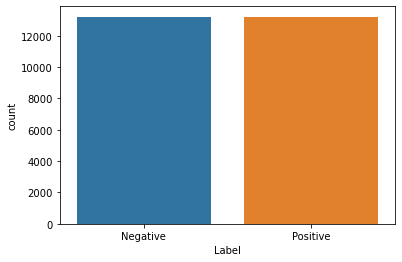

In [15]:
sns.countplot(x='Label', data=df)

In [16]:
X_train.shape

(24000, 500)

In [17]:
model = Sequential()

# input layer
model.add(Embedding(vocab_size, 256, input_length=maxlen))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 256)          3478528   
_________________________________________________________________
flatten (Flatten)            (None, 128000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16384128  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 19,862,785
Trainable params: 19,862,785
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history=model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])


Epoch 1/6
150/150 [==============================] - 41s 274ms/step - loss: 0.4742 - accuracy: 0.7805 - val_loss: 0.2473 - val_accuracy: 0.9017
Epoch 2/6
150/150 [==============================] - 46s 307ms/step - loss: 0.2124 - accuracy: 0.9172 - val_loss: 0.2420 - val_accuracy: 0.9060
Epoch 3/6
150/150 [==============================] - 43s 289ms/step - loss: 0.2026 - accuracy: 0.9196 - val_loss: 0.2315 - val_accuracy: 0.9100
Epoch 4/6
150/150 [==============================] - 40s 267ms/step - loss: 0.1947 - accuracy: 0.9236 - val_loss: 0.2356 - val_accuracy: 0.9115
Epoch 5/6
150/150 [==============================] - 45s 301ms/step - loss: 0.1880 - accuracy: 0.9272 - val_loss: 0.2344 - val_accuracy: 0.9067
Epoch 6/6
188/188 [==============================] - 7s 38ms/step - loss: 0.2135 - accuracy: 0.9158
Test Score: 0.21347320079803467
Test Accuracy: 0.9158333539962769


In [19]:
pred = model.predict(X_test)

In [20]:
pred_list = []
for i in pred:
    if i > 0.5:
        pred_list.append(1)
    else:
        pred_list.append(0)

In [21]:
y_test

array([0, 1, 1, ..., 0, 0, 1])

In [22]:
pred_list = array(pred_list)

In [23]:
pred_list

array([0, 1, 1, ..., 0, 0, 1])

In [24]:
print(confusion_matrix(y_test, pred_list))

[[2437  209]
 [ 296 3058]]


In [25]:
print(classification_report(y_test, pred_list))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2646
           1       0.94      0.91      0.92      3354

    accuracy                           0.92      6000
   macro avg       0.91      0.92      0.91      6000
weighted avg       0.92      0.92      0.92      6000



In [26]:
print(r2_score(y_test, pred))

0.7493783814003382


In [27]:
cf_matrix = confusion_matrix(y_test, pred_list)

<AxesSubplot:>

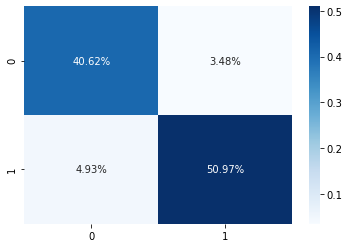

In [28]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot:>

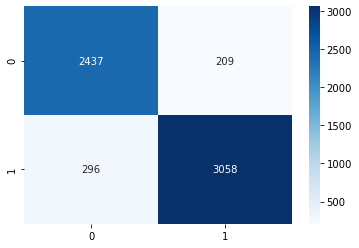

In [29]:
sns.heatmap(cf_matrix, annot=True, fmt='d',cmap='Blues')

<AxesSubplot:>

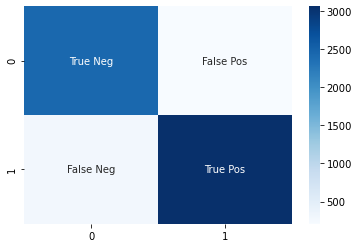

In [30]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [31]:
data = {
    'n_epochs':[n_epochs],
    'max_words':[max_words],
    'maxlen':[maxlen],
    'dfsize':[n_df_size],
    'model_name':[model_name_for_sql],
    'true_neg':[cf_matrix[0][0]],
    'false_pos':[cf_matrix[0][1]],
    'false_neg':[cf_matrix[1][0]],
    'true_pas':[cf_matrix[1][1]],
    'date':[datetime.datetime.now()],
    'test_score':[scores[0]],
    'test_accuracy':[scores[1]]
    }

In [32]:
modelDf = pd.DataFrame(data)

In [33]:
modelhisDf = pd.DataFrame(history.history)

In [34]:
modelhisDf['model_name'] = model_name_for_sql

In [35]:
modelhisDf

,loss,accuracy,val_loss,val_accuracy,model_name
0,0.474191,0.780521,0.247253,0.901667,selfnn
1,0.212432,0.917188,0.242032,0.906042,selfnn
2,0.202632,0.919583,0.231535,0.910000,selfnn
3,0.194730,0.923594,0.235605,0.911458,selfnn
4,0.188015,0.927240,0.234354,0.906667,selfnn
5,0.182109,0.929323,0.235324,0.909375,selfnn


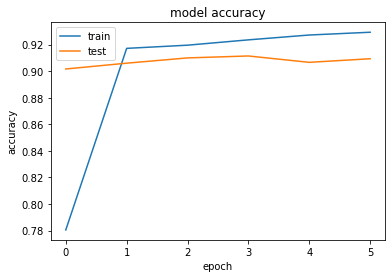

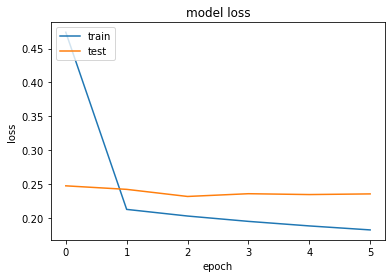

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [37]:
if tosql:
    db.nnmatrix.insert_many(modelDf.to_dict('records'))
    db.nnhistory.insert_many(modelhisDf.to_dict('records'))